In [1]:
#External libraries

import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import readgadget

In [2]:
import numpy as np
import time
import sys
import scipy.spatial
import os
import gc

# Ensure module path is correctly added for relative imports
module_path = os.path.abspath(os.path.join(''))
if module_path not in sys.path:
    sys.path.append(module_path)

####################################################################################################

#-------------------  These libraries are required for evaluating the functions  -------------------

import numpy as np
import scipy
from scipy import interpolate
import time
import copy
import pyfftw
import warnings
import smoothing_library as SL
import MAS_library as MASL

####################################################################################################

#--------------------------------------  Function Definitions  -------------------------------------

####################################################################################################

def cdf_vol_knn(vol):
    r'''
    Returns interpolating functions for empirical CDFs of the given $k$-nearest neighbour distances.
    
    Parameters
    ----------
    vol : numpy float array of shape ``(n_query, n_kNN)``
        Sorted array of nearest neighbour distances, where 'n_query' is the number of query points and 'n_kNN' is the number of nearest neighbours queried.

    Returns
    -------
    cdf: list of function objects
        list of interpolated empirical CDF functions that can be evaluated at desired distance bins.
    '''
    
    #-----------------------------------------------------------------------------------------------

    #Initialising a list to contain the interpolating functions
    cdf = []

    #-----------------------------------------------------------------------------------------------

    #Inferring the number of query points and nearest neighbours
    n = vol.shape[0]
    l = vol.shape[1]

    #-----------------------------------------------------------------------------------------------

    #Calculating the empirical CDF
    gof = ((np.arange(0, n) + 1) / (n*1.0))
    for c in range(l):
        ind = np.argsort(vol[:, c])
        s_vol= vol[ind, c]
        #Calculating the interpolating function
        cdf.append(interpolate.interp1d(s_vol, gof, kind='linear', bounds_error=False))
        
    return cdf

####################################################################################################

def calc_kNN_CDF(vol, bins):
    r'''
    Returns the kNN-CDFs for the given nearest-neighbour distances, evaluated at the given distance bins.

    Parameters
    ----------
    vol : numpy float array of shape ``(n_query, n_kNN)``
        2D array containing sorted 1D arrays of nearest-neighbour distances, where 'n_query' is the number of query points and 'n_kNN' is the number of nearest-neighbours queried. `vol[:, i]` should be the array with the sorted $k_i^{th}$ nearest-neighbour distances.
    bins : list of numpy float array
        list of distance scale arrays at which the CDFs need to be evaluated (units must be same as in `vol`).

    Returns
    -------
    data : list of numpy float array
        kNN-CDFs evaluated at the desired distance bins. ``data[i]`` is the $k_i$NN-CDF if ``vol[:, i]`` containts the $k_i^{th}$ nearest-neigbour distances.
    '''

    #-----------------------------------------------------------------------------------------------

    #Initialising the list of kNN-CDFs
    data = []

    #-----------------------------------------------------------------------------------------------

    #Computing the interpolated empirical CDFs using the nearest-neighbour distances
    cdfs = cdf_vol_knn(vol)

    #-----------------------------------------------------------------------------------------------

    #Looping over the nearest-neighbour indices
    for i in range(vol.shape[1]):

        #-------------------------------------------------------------------------------------------

        #Finding the minimum and maximum values of the NN distances
        min_dist = np.min(vol[:, i])
        max_dist = np.max(vol[:, i])

        #-------------------------------------------------------------------------------------------

        #Finding if any of the user-input bins lie outside the range spanned by the NN distances
        bin_mask = np.searchsorted(bins[i], [min_dist, max_dist])
        if bin_mask[1]!=len(bins[i]):
            if bins[i][bin_mask[1]] == max_dist:
                bin_mask[1] += 1

        #-------------------------------------------------------------------------------------------
                
        NNcdf = np.zeros(len(bins[i]))
        
        #Setting the value of the CDFs at scales smaller than the smallest NN distance to 0
        NNcdf[:bin_mask[0]] = 0
        
        NNcdf[bin_mask[0]:bin_mask[1]] = cdfs[i](bins[i][bin_mask[0]:bin_mask[1]])
        
        #Setting the value of the CDFs at scales larger than the largest NN distance to 1
        NNcdf[bin_mask[1]:] = 1
        
        data.append(NNcdf)
        
    return data

####################################################################################################

def create_query_3D(query_type, query_grid, BoxSize):
    '''
    Generates an array of query points; can be either randomly drawn from a uniform distribution defined over the box or put on a uniform grid.

    Parameters
    ----------
    query_type : {'grid', 'random'}, str
        the type of query points to be generated; should be 'grid' for query points defined on a uniform grid and 'random' for query points drawn from a uniform random distribution.
    query_grid : int
        the 1D size of the query points array; the total number of query points generated will be ``query_grid**3``.
    BoxSize : float
        the size of the 3D box of the input density field, in Mpc/h.

    Returns
    -------
    query_pos : numpy float array of shape ``(query_grid**3, 3)``
        array of query point positions. For each query point in the array, the first, second and third entries are the x, y and z coordinates respectively, in Mpc/h.

    Raises
    ------
    ValueError
        if an unknown query type is provided.
        
    See Also
    --------
    kNN_ASMR.HelperFunctions.create_query_2DA : generates query points in 2D angular coordinates.
    '''

    if query_type == 'grid':

        #Creating a grid of query points
        x_ = np.linspace(0., BoxSize, query_grid)
        y_ = np.linspace(0., BoxSize, query_grid)
        z_ = np.linspace(0., BoxSize, query_grid)

        x, y, z = np.array(np.meshgrid(x_, y_, z_, indexing='xy'))

        query_pos = np.zeros((query_grid**3, 3))
        query_pos[:, 0] = np.reshape(x, query_grid**3)
        query_pos[:, 1] = np.reshape(y, query_grid**3)
        query_pos[:, 2] = np.reshape(z, query_grid**3)

    elif query_type == 'random':

        #Creating a set of randomly distributed query points
        query_pos = np.random.rand(query_grid**3, 3)*BoxSize

    else:   
        raise ValueError(f"Unknown query type: {query_type}; please provide a valid query type")
    
    return query_pos
    
####################################################################################################

#----------------------------------------  END OF PROGRAM!  ----------------------------------------

####################################################################################################


#################################################################################################################

#----------------------------------------  Function Definitions  ----------------------------------------

def TracerAuto3D(boxsize, kList, BinsRad, QueryPos, TracerPos, ReturnNNdist=False,Verbose=False):
    
    r'''
    Computes the $k$NN-CDFs in 3D coordinates (Banerjee & Abel (2021)[^1]) of the provided discrete tracer set (`TracerPos`), 
    evaluated at the provided radial distance scales `BinsRad`, for all $k$ in `kList`. Each $k$NN-CDF measures the probability
    $P_{\geq k}(r)$ of finding at least $k$ tracers in a randomly placed sphere of radius $r$. The $k$NN-CDFs quantify the spatial 
    clustering of the tracers.
    		
    Parameters
    ----------
    kList : list of ints
        the list of nearest neighbours to calculate the distances to. For example, if ``kList = [1, 2, 4]``, the first, second and 
        fourth-nearest neighbour distributions will be computed.
    BinsRad : list of numpy float array
        list of radial distance arrays (in Mpc/h) for each nearest neighbour. The $i^{th}$ element of the 
        list should contain a numpy array of the desired distances for the nearest neighbour specified by the $i^{th}$ element of `kList`.
    QueryPos : numpy float array of shape ``(n_query, 3)``
        array of 3D locations for the query points. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos : numpy float array of shape ``(n_tracer, 3)``
        array of 3D locations for the discrete tracers. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    ReturnNNdist : bool, optional
        if set to ``True``, the sorted arrays of NN distances will be returned along with the $k$NN-CDFs, by default ``False``.
    Verbose : bool, optional
        if set to ``True``, the time taken to complete each step of the calculation will be printed, by default ``False``.

    Returns
    -------
    kNN_results: tuple of lists or list of numpy float arrays
        results of the kNN computation. If `ReturnNNdist` is ``True``, returns the tuple ``(p_gtr_k_list, vol)`` where `p_gtr_k_list` 
        is the list of auto kNN-CDFs, and `vol` is the list of NN distances. If `ReturnNNdist` is ``False``, returns `p_gtr_k_list` only
        
    Raises
    ------
    ValueError
        if the given query points are not on a three-dimensional grid.
    ValueError
        if x,y, or z coordinate of any of the query points is not in ``(0, boxsize)``.
    ValueError
        if x,y, or z coordinate of any of the tracer points is not in ``(0, boxsize)``..
    ValueError
        if the given tracer points are not on a three-dimensional grid.

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Nearest neighbour distributions: New statistical measures for cosmological clustering, 
    [Monthly Notices of the Royal Astronomical Society](https://doi.org/10.1093/mnras/staa3604), Volume 500, Issue 4, February 2021, Pages 5479–5499
        
    '''
    
    #-----------------------------------------------------------------------------------------------

    if Verbose: total_start_time = time.perf_counter()

    #-----------------------------------------------------------------------------------------------
        
    #Step 0: Check all inputs are consistent with the function requirement

    if Verbose: print('Checking inputs ...')

    if QueryPos.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for query points: array containing the query point positions must be of shape (n_query, 3), ' \
        'where n_query is the number of query points.')

    if np.any((QueryPos[:, 0] <= 0) | (QueryPos[:, 0] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < x < boxsize.')

    if np.any((QueryPos[:, 1] <= 0) | (QueryPos[:, 1] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < y < boxsize.')

    if np.any((QueryPos[:, 2] <= 0) | (QueryPos[:, 2] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < z < boxsize.')

    if np.any((TracerPos[:, 0] <= 0) | (TracerPos[:, 0] >= boxsize)):
        raise ValueError('Invalid tracer point position(s): please ensure 0 < x < boxsize.')

    if np.any((TracerPos[:, 1]<= 0) | (TracerPos[:, 1]>= boxsize)):
        raise ValueError('Invalid tracer point position(s): please ensure 0 < y < boxsize.')

    if np.any((TracerPos[:, 2]<= 0) | (TracerPos[:, 2]>= boxsize)):
        raise ValueError('Invalid tracer point position(s): please ensure 0 < z < boxsize.')

    if TracerPos.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for tracers: array containing the tracer positions must be of shape (n_tracer, 3), ' \
        'where n_tracer is the number of tracers.')

    if Verbose: print('\tdone.')

    #-----------------------------------------------------------------------------------------------
        
    #Building the tree
    if Verbose: 
        start_time = time.perf_counter()
        print('\nbuilding the tree ...')
    xtree    = scipy.spatial.cKDTree(TracerPos, boxsize=boxsize)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the NN distances
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer NN distances ...')
    dists, _= xtree.query(QueryPos, k=max(kList), workers=-1)
    vol = dists[:, np.array(kList)-1]
    
    
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the kNN-CDFs
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer auto-CDFs P_{>=k} ...')
    p_gtr_k_list = calc_kNN_CDF(vol, BinsRad)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------

    #Collecting the results
    if ReturnNNdist:
        kNN_results = (p_gtr_k_list, vol)
    else:
        kNN_results = (p_gtr_k_list, None)

    #-----------------------------------------------------------------------------------------------

    if Verbose:
        print('\ntotal time taken: {:.2e} s.'.format(time.perf_counter()-total_start_time))
    
    return kNN_results



In [4]:
# #Plotting settings

# import matplotlib.pyplot as plt
# from matplotlib import gridspec
# import matplotlib.patches as mpatches
# plt.rcParams["axes.linewidth"]  = 2.0
# plt.rcParams["xtick.major.size"]  = 10
# plt.rcParams["xtick.minor.size"]  = 5
# plt.rcParams["ytick.major.size"]  = 10
# plt.rcParams["ytick.minor.size"]  = 5
# plt.rcParams["xtick.direction"]  = "in"
# plt.rcParams["ytick.direction"]  = "in"
# plt.rcParams["legend.frameon"] = 'False'
# plt.rcParams['figure.figsize'] = [7, 7]
# plt.rcParams['font.family']="serif"
# plt.rc("text", usetex=True)
# plt.rc("font", size=20)

In [5]:
# #The module that needs to be tested

# #Necessary for relative imports (see https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im)
# module_path = os.path.abspath(os.path.join('../../'))           # '../../' is needed because the parent directory is two directories upstream of this test directory
# if module_path not in sys.path:
#     sys.path.append(module_path)

# #from kNN_ASMR import HelperFunctions as hf
# from kNN_3D import TracerAuto3D as TA 

Refernce: 	arXiv:2007.13342 [astro-ph.CO]

Banerjee, Abel, "Nearest Neighbor distributions: new statistical measures for cosmological clustering", 2020, MNRAS

# Tracer Auto 3D

## Comparison with an analytic result: Poisson point process on a uniform field

In [6]:
boxsize=1000 #Mpc/h
nbar=(32**3)/(boxsize**3)
# Making Tracer Positions

r_min, r_max = 0.5, 30  # or maybe 0.5 to 15 for more dynamic range
no_bins = 20
#r_edges = np.logspace(np.log10(r_min), np.log10(r_max), no_bins + 1)
r_edges = np.linspace(r_min, r_max, no_bins + 1)

binrad = 0.5 * (r_edges[:-1] + r_edges[1:])

#Making query positions
print(binrad)

[ 1.2375  2.7125  4.1875  5.6625  7.1375  8.6125 10.0875 11.5625 13.0375
 14.5125 15.9875 17.4625 18.9375 20.4125 21.8875 23.3625 24.8375 26.3125
 27.7875 29.2625]


In [7]:
tracerpos = boxsize * np.random.rand(32**3, 3)
querypos = boxsize * np.random.rand(128**3, 3)


The analytic expression for 1-NN, 2NN of a Poisson sampling of a uniform field looks like:

$$CDF_{\text{1NN}}(V)=1-exp(-\bar{n}V)$$
$$CDF_{\text{2NN}}(V)=1-exp(-\bar{n}V)-(\bar{n}V)exp(-\bar{n}V)$$

Comparing this with the empirical calculation:

Checking inputs ...
	done.

building the tree ...
	done; time taken: 1.09e-02 s.

computing the tracer NN distances ...
	done; time taken: 1.25e+00 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 4.50e-01 s.

total time taken: 1.75e+00 s.


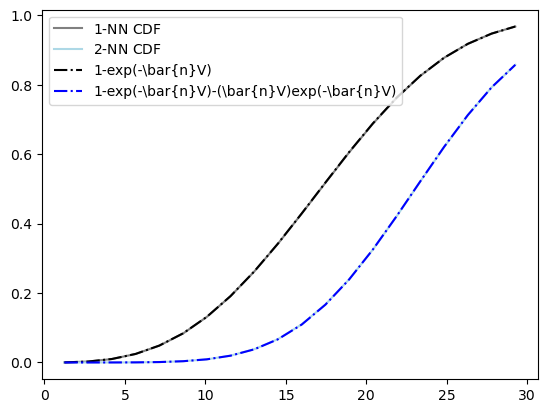

In [8]:
cdf=TracerAuto3D(boxsize=boxsize, kList=[1,2], BinsRad=[binrad, binrad], QueryPos=querypos, TracerPos=tracerpos, ReturnNNdist=True,Verbose=True)
analyticcdf1=1-np.exp(-nbar*(4/3)*np.pi*binrad**3)
analyticcdf2=1-np.exp(-nbar*(4/3)*np.pi*binrad**3)-(nbar*(4/3)*np.pi*binrad**3)*np.exp(-nbar*(4/3)*np.pi*binrad**3)
plt.plot(binrad, cdf[0][0], linestyle="-", color="grey", label=r"$1$-NN CDF")
plt.plot(binrad, cdf[0][1], linestyle="-", color="lightblue", label=r"$2$-NN CDF")
plt.plot(binrad, analyticcdf1, linestyle="-.", color="k", label=r"1-exp(-\bar{n}V)")
plt.plot(binrad, analyticcdf2, linestyle="-.", color="blue", label=r"1-exp(-\bar{n}V)-(\bar{n}V)exp(-\bar{n}V)")

plt.legend()

## For large-scale structure: Auto-correlation of $10^5$ most massive halos from the QUIJOTE Snaps

In [9]:
no_bins=13
r_min, r_max = 5, 35 #Mpc/h
r_edges = np.logspace(np.log10(r_min), np.log10(r_max),no_bins + 1)
binrad = 0.5 * (r_edges[:-1] + r_edges[1:])


Checking inputs ...
	done.

building the tree ...
	done; time taken: 3.52e-02 s.

computing the tracer NN distances ...
	done; time taken: 1.77e+01 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 7.44e+00 s.

total time taken: 2.54e+01 s.
Checking inputs ...
	done.

building the tree ...
	done; time taken: 4.78e-02 s.

computing the tracer NN distances ...
	done; time taken: 2.35e+01 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 7.34e+00 s.

total time taken: 3.11e+01 s.


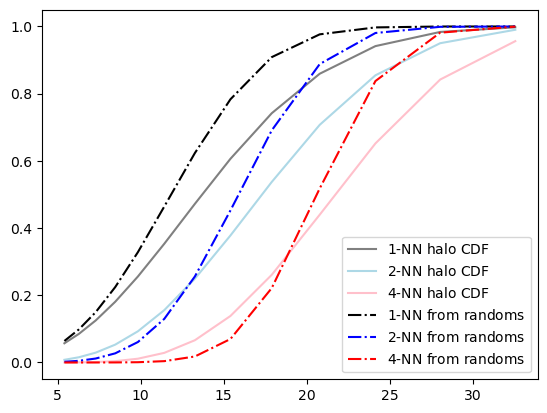

In [10]:
QueryPos=boxsize*np.random.rand(256**3,3)
RandomPos=boxsize*np.random.rand(10**5,3)
halos_fid = np.load(f'/media/anargha/6a5e2c73-73b9-4e46-ae8d-9c06f8f23a69/Arka_Data/Halos_FoF/Top10^5_mostmassivehalos/fiducial/0/halopos_0.npy')
halos_fid = np.mod(halos_fid, boxsize)
cdfs=TracerAuto3D(boxsize=boxsize, kList=[1,2,4], BinsRad=[binrad,binrad,binrad], QueryPos=QueryPos, TracerPos=halos_fid, Verbose=True)
cdfs_random=TracerAuto3D(boxsize=boxsize, kList=[1,2,4], BinsRad=[binrad,binrad,binrad], QueryPos=QueryPos, TracerPos=RandomPos, Verbose=True)

plt.plot(binrad, cdfs[0][0], linestyle="-", color="grey", label=r"$1$-NN halo CDF")
plt.plot(binrad, cdfs[0][1], linestyle="-", color="lightblue", label=r"$2$-NN halo CDF")
plt.plot(binrad, cdfs[0][2], linestyle="-", color="pink", label=r"$4$-NN halo CDF")
plt.plot(binrad, cdfs_random[0][0], linestyle="-.", color="k", label=r"$1$-NN from randoms")
plt.plot(binrad, cdfs_random[0][1], linestyle="-.", color="blue", label=r"$2$-NN from randoms")
plt.plot(binrad, cdfs_random[0][2], linestyle="-.", color="red", label=r"$4$-NN from randoms")

plt.legend()

# Tracer-Tracer Cross-Correlations 3D 

In [3]:
def TracerTracerCross3D(boxsize, kA_kB_list, BinsRad, QueryPos, TracerPos_A, TracerPos_B, Verbose=False):
    
    r'''
    Returns the probabilities $P_{\geq k_A}$, $P_{\geq k_B}$ and $P_{\geq k_A, \geq k_B}$ for ($k_A$, $k_B$) in `kA_kB_list` 
    that quantify the extent of the spatial cross-correlation between the given sets of discrete tracers, `TracerPos_A`, `TracerPos_B`.
    	
    1. $P_{\geq k_A}(r)$: 
    	the $k_A$NN-CDF of the first set of discrete tracers, evaluated at radial distance scale $r$
    		
    2. $P_{\geq k_B}(\theta)$: 
    	the $k_B$NN-CDF of the second set of discrete tracers, evaluated at radial distance scale $r$
    		
    3.  $P_{\geq k_A, \geq k_B}(\theta)$:
    	the joint probability of finding at least $k_A$ set A tracers and at least $k_B$ set B tracers within a sphere of radius $r$
    		
    The excess cross-correlation (Banerjee & Abel 2023)[^1] can be computed trivially from the quatities (see the `kNN_ASMR.HelperFunctions.kNN_excess_cross_corr()` method to do this)
    	
    $$\psi_{k_A, k_B} = P_{\geq k_A, \geq k_B}/(P_{\geq k_A} \times P_{\geq k_B})$$
    		
    Parameters
    ----------
    kA_kB_list : list of int tuples
        nearest-neighbour combinations for which the cross-correlations need to be computed (see notes for more details)
    BinsRad : list of numpy float array
        list of radial distance scale arrays (in Mpc/h) for each nearest neighbour combination in `kA_kB_list`. The $i^{th}$ element of the 
        list should contain a numpy array of the desired distances for the $i^{th}$ nearest neighbour combination.
    QueryPos : numpy float array of shape ``(n_query, 3)``
        array of 3D locations for the query points. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos_A : numpy float array of shape ``(n_tracer, 3)``
        array of 3D locations for the first set of discrete tracers. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos_B : numpy float array of shape ``(n_tracer, 3)``
        array of 3D locations for the second set of discrete tracers. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    Verbose : bool, optional
        if set to ``True``, the time taken to complete each step of the calculation will be printed, by default ``False``.

    Returns
    -------
    p_gtr_kA_list: list of numpy float arrays
        list of auto kNN-CDFs of the first set of discrete tracers evaluated at the desired distance bins. The $i^{th}$ element represents the $k_A^i$NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
        
    p_gtr_kB_list: list of numpy float arrays
        list of auto kNN-CDFs of the second set of discrete tracers evaluated at the desired distance bins. The $i^{th}$ element represents the $k_B^i$NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
    
    p_gtr_kA_kB_list: list of numpy float arrays
        list of joint tracer-tracer nearest neighbour distributions evaluated at the desired distance bins. The $i^{th}$ element represents the joint {$k_A^i$, $k_B^i$}NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
        
    Raises
    ------
    ValueError
        if the lengths of `BinsRad` and `kA_kB_list` do not match.
    ValueError
        if the given query points are not on a three-dimensional grid.
    ValueError
        if x,y, or z coordinates of any of the query points is not in ``(0, boxsize)``.
    ValueError
        if x,y, or z coordinates of any of the tracer points is not in ``(0, boxsize)``.
    ValueError
        if any of the given tracer points are not on a three-dimensional grid.

    Notes
    -----
    The parameter `kA_kB_list` should provide the desired combinations of NN indices for the two tracers sets being cross-correlated. For example, if you wish to compute the joint {1,1}, {1,2} and {2,1}NN-CDFs, then set
            
        kA_kB_list = [(1,1), (1,2), (2,1)]

    Please note that if the number density of one set of tracers is significantly smaller than the other, the joint kNN-CDFs approach the auto kNN-CDFs of the less dense tracer set. In this scenario, it may be better to treat the denser tracer set as a continuous field and use the `TracerFieldCross2DA()` method instead to conduct the cross-correlation analysis  (see Gupta & Banerjee (2024)[^2] for a detailed discussion).

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Cosmological cross-correlations and nearest neighbour distributions, [Monthly Notices of the Royal Astronomical Society](https://doi.org/10.1093/mnras/stab961), Volume 504, Issue 2, June 2021, Pages 2911–2923
        
    '''
    
    #-----------------------------------------------------------------------------------------------

    if Verbose: total_start_time = time.perf_counter()

    #-----------------------------------------------------------------------------------------------
        
    #Step 0: Check all inputs are consistent with the function requirement

    if Verbose: print('Checking inputs ...')

    if len(BinsRad)!=len(kA_kB_list): 
        raise ValueError("length of 'BinsRad' must match length of 'kA_kB_list'.")

    if QueryPos.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for query points: array containing the query point positions must be of shape (n_query,3),' \
        ' where n_query is the number of query points.')
    
    if np.any((QueryPos[:, 0] <= 0) | (QueryPos[:, 0] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < x < boxsize.')

    if np.any((QueryPos[:, 1] <= 0) | (QueryPos[:, 1] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < y < boxsize.')

    if np.any((QueryPos[:, 2] <= 0 ) | (QueryPos[:, 2] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < z < boxsize.')

    if np.any((TracerPos_A[:, 0] <= 0) | (TracerPos_A[:, 0] >= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < x < boxsize.')

    if np.any((TracerPos_A[:, 1]<= 0) | (TracerPos_A[:, 1]>= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < y < boxsize.')

    if np.any((TracerPos_A[:, 2]<= 0) | (TracerPos_A[:, 2]>= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < z < boxsize.')

    if np.any((TracerPos_B[:, 0] <= 0) | (TracerPos_B[:, 0] >= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < x < boxsize.')

    if np.any((TracerPos_B[:, 1]<= 0) | (TracerPos_B[:, 1]>= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < y < boxsize.')

    if np.any((TracerPos_B[:, 2]<= 0) | (TracerPos_B[:, 2]>= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < z < boxsize.')

    
    if TracerPos_A.shape[1]!=3 or TracerPos_B.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for tracers: array containing the tracer positions must be of shape (n_tracer, 3),' \
        ' where n_tracer is the number of tracers.')

    if Verbose: print('\tdone.')

    #-----------------------------------------------------------------------------------------------

    #Figuring out the NN indices from the kA_kB_list
    kList_A, kList_B = [], []
    for kA, kB in kA_kB_list:
        kList_A.append(kA)
        kList_B.append(kB)
    kMax_A, kMax_B = max(kList_A), max(kList_B)

    #-----------------------------------------------------------------------------------------------
        
    #Building the trees
    if Verbose: 
        start_time = time.perf_counter()
        print('\nbuilding the trees ...')
        start_time_A = time.perf_counter()
    xtree_A = scipy.spatial.cKDTree(TracerPos_A, boxsize=boxsize)
    if Verbose: 
        print('\tfirst set of tracers done; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_A))
        start_time_B = time.perf_counter()
    xtree_B = scipy.spatial.cKDTree(TracerPos_B, boxsize=boxsize)
    if Verbose: 
        print('\tsecond set of tracers done; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_B))
        print('\tcombined time: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the NN distances
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer NN distances ...')
    vol_A, _ = xtree_A.query(QueryPos, k=kMax_A)
    vol_B, _ = xtree_B.query(QueryPos, k=kMax_B)
    req_vol_A = vol_A[:, np.array(kList_A)-1]
    req_vol_B = vol_B[:, np.array(kList_B)-1]
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------
    
    #Calculating the auto kNN-CDFs
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...')
    p_gtr_kA_list = calc_kNN_CDF(req_vol_A, BinsRad)
    p_gtr_kB_list = calc_kNN_CDF(req_vol_B, BinsRad)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------

    #Calculating the joint kNN-CDFs
    if Verbose: 
        start_time = time.perf_counter()
        print('\ncomputing the joint-CDFs P_{>=kA, >=kB} ...')
    joint_vol = np.zeros((vol_A.shape[0], len(kA_kB_list)))
    for i, _ in enumerate(kA_kB_list):
        joint_vol[:, i] = np.maximum(req_vol_A[:, i], req_vol_B[:, i])
    p_gtr_kA_kB_list = calc_kNN_CDF(joint_vol, BinsRad)
    if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

    #-----------------------------------------------------------------------------------------------

    if Verbose:
        print('\ntotal time taken: {:.2e} s.'.format(time.perf_counter()-total_start_time))
    
    return p_gtr_kA_list, p_gtr_kB_list, p_gtr_kA_kB_list

####################################################################################################


We first calculate the kNN CDFs for uncorrelated fields, and then do the same for the correlated fields and compare. To compare uncorrelated fields, we randomly choose $10^5$ particles from different realizations of a snap. To compare correlated fields, we choose the top $2\times 10^5$ halos from the same realization, split the sample along the median, and cross-correlate.

Note that the sampling needs to be done without replacement

Note that halos are biased tracers of teh density field, and hence we can reiterate the same thing with simulation particles. But if we are consistent with our choice of tracers, this should not matter.

First, for tracers tracing different realizations of the density field

In [4]:
boxsize=1000
no_bins=20
r_min, r_max = 8, 30 #Mpc/h
r_edges = np.logspace(np.log10(r_min), np.log10(r_max),no_bins + 1)
binrad = 0.5 * (r_edges[:-1] + r_edges[1:])

RandomPos=boxsize*np.random.rand(10**5,3)
QueryPos=boxsize*np.random.rand(256**3,3)

In [5]:
snapshot1='/media/anargha/6a5e2c73-73b9-4e46-ae8d-9c06f8f23a69/fiducial/100/snapdir_004/snap_004'
snapshot2='/media/anargha/6a5e2c73-73b9-4e46-ae8d-9c06f8f23a69/fiducial/199/snapdir_004/snap_004'

ptype = [1] #DM is 1, neutrinos is [2]
pos1   = readgadget.read_block(snapshot1, "POS ", ptype)/1e3 #positions in Mpc/h
pos2   = readgadget.read_block(snapshot2, "POS ", ptype)/1e3 #positions in Mpc/h


In [6]:

#creating a random mask that only selects those positions prescribed by a random number generator
mask1=np.random.choice(pos1.shape[0], size=10**5, replace=False)
mask2=np.random.choice(pos2.shape[0], size=10**5, replace=False)

#Choosing random 10^5 points
pos1=pos1[mask1]
pos2=pos2[mask2]


In [7]:
autoA,autoB,joint=TracerTracerCross3D(boxsize=boxsize, kA_kB_list=[(1,1),(2,2),(4,4)], BinsRad=[binrad,binrad,binrad], QueryPos=QueryPos, TracerPos_A=pos1, TracerPos_B=pos2, Verbose=True)

Checking inputs ...
	done.

building the trees ...
	first set of tracers done; time taken: 4.12e-02 s.
	second set of tracers done; time taken: 4.03e-02 s.
	combined time: 8.17e-02 s.

computing the tracer NN distances ...
	done; time taken: 1.55e+02 s.

computing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...
	done; time taken: 1.35e+01 s.

computing the joint-CDFs P_{>=kA, >=kB} ...
	done; time taken: 6.59e+00 s.

total time taken: 1.75e+02 s.


We impose a further scale cut, such that $r_{min}=min(binrad[0],CDF_{0.025})$, and $r_{max}=min(binrad[-1],CDF_{0.975})$

Choosing $2\times 10^5$ particles the same underlying density field ...

In [8]:
snapshot='/media/anargha/6a5e2c73-73b9-4e46-ae8d-9c06f8f23a69/fiducial/100/snapdir_004/snap_004'

ptype = [1] #DM is 1, neutrinos is [2]
pos   = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h



In [9]:

#creating a random mask that only selects those positions prescribed by a random number generator
mask=np.random.choice(pos.shape[0], size=2*10**5, replace=False)

#Choosing random 10^5 points
pos=pos[mask]


Partitioning the sample...

In [10]:
pos_1=np.zeros((10**5,3))
pos_2=np.zeros((10**5,3))

for i in range(10**5):
    pos_1[i]=pos[2*i]
    pos_2[i]=pos[2*i+1]

print(pos_1.shape)
print(pos_2.shape)

(100000, 3)
(100000, 3)


In [11]:
autoA_1,autoB_1,joint_1=TracerTracerCross3D(boxsize=boxsize, kA_kB_list=[(1,1),(2,2),(4,4)], BinsRad=[binrad,binrad,binrad], QueryPos=QueryPos, TracerPos_A=pos_1, TracerPos_B=pos_2, Verbose=True)


Checking inputs ...
	done.

building the trees ...
	first set of tracers done; time taken: 4.53e-02 s.
	second set of tracers done; time taken: 4.43e-02 s.
	combined time: 8.97e-02 s.

computing the tracer NN distances ...
	done; time taken: 1.47e+02 s.

computing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...
	done; time taken: 1.48e+01 s.

computing the joint-CDFs P_{>=kA, >=kB} ...
	done; time taken: 6.74e+00 s.

total time taken: 1.69e+02 s.


Calculating the auto CDFs, we expect them to show no difference.

Comparing the joint CDFs ...

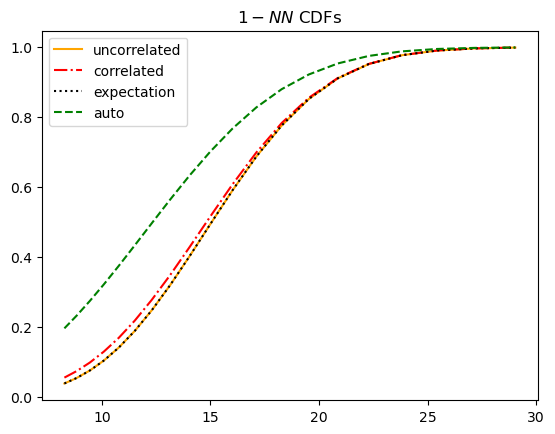

In [12]:
plt.plot(binrad, joint[0], linestyle="-", color="orange", label="uncorrelated")

plt.plot(binrad, joint_1[0], linestyle="-.", color="red", label="correlated")

plt.plot(binrad, autoA[0]*autoB[0], linestyle=":", color="k", label="expectation")

plt.plot(binrad, autoA_1[0], linestyle="--", color="green", label="auto")

plt.title(r'$1-NN$ CDFs')

plt.legend()

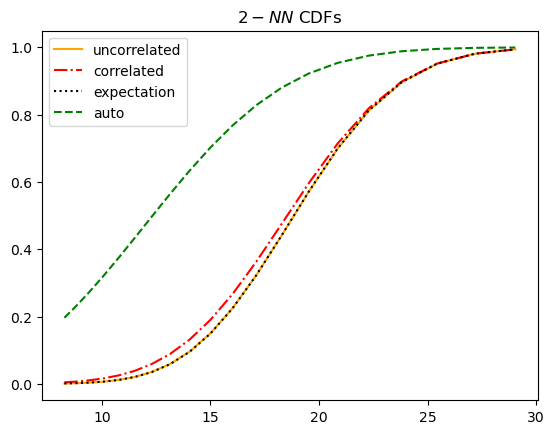

In [13]:
plt.plot(binrad, joint[1], linestyle="-", color="orange", label="uncorrelated")

plt.plot(binrad, joint_1[1], linestyle="-.", color="red", label="correlated")

plt.plot(binrad, autoA[1]*autoB[1], linestyle=":", color="k", label="expectation")

plt.plot(binrad, autoA_1[0], linestyle="--", color="green", label="auto")

plt.title(r'$2-NN$ CDFs')

plt.legend()

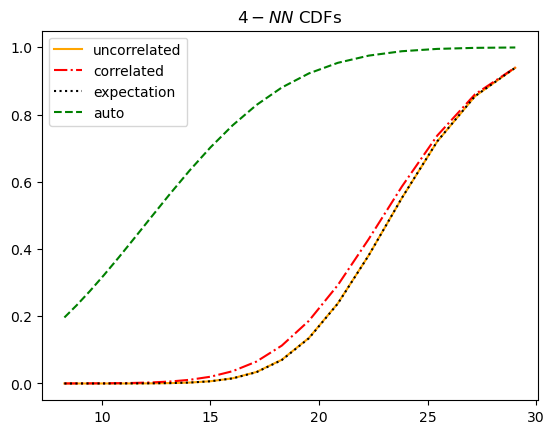

In [14]:
plt.plot(binrad, joint[2], linestyle="-", color="orange", label="uncorrelated")

plt.plot(binrad, joint_1[2], linestyle="-.", color="red", label="correlated")

plt.plot(binrad, autoA[2]*autoB[2], linestyle=":", color="k", label="expectation")

plt.plot(binrad, autoA_1[0], linestyle="--", color="green", label="auto")

plt.title(r'$4-NN$ CDFs')

plt.legend()

In [15]:
def TracerTracerCross3D_DataVector(boxsize, kA_kB_list, BinsRad, QueryPos, TracerPos_A_dict, TracerPos_B, Verbose=False ):
    r'''
    Returns the probabilities $P_{\geq k_{A_i}}$, $P_{\geq k_B}$ and $P_{\geq k_{A_i}, \geq k_B}$ for ($k_{A_i}$, $k_B$) in `kA_kB_list` for various 
    realizations of Tracer A, while keeping the set Tracer B constant. Refer to Notes to understand why this might be useful. These quantify
    the extent of the spatial cross-correlation between the given sets of discrete tracers, the $i^{\text{th}}$ realization of `TracerPos_A`, `TracerPos_B`.
    We do not vary the 'kA_kB_list' as a function of the realizations of Tracer A.
    	
    1. $P_{\geq k_{A_i}}(r)$: 
    	the $k_A$NN-CDF of the $i^{\text{th}}$ realization of the first set of discrete tracers, evaluated at radial distance scale $r$
    		
    2. $P_{\geq k_B}(\theta)$: 
    	the $k_B$NN-CDF of the second set of discrete tracers, evaluated at radial distance scale $r$
    		
    3.  $P_{\geq k_{A_i}, \geq k_B}(\theta)$:
    	the joint probability of finding at least $k_A$ set A tracers and at least $k_B$ set B tracers within a sphere of radius $r$, for the
        $i^{\text{th}}$ realization of Tracer A
    		
    The excess cross-correlation (Banerjee & Abel 2023)[^1] can be computed trivially from the quatities (see the `kNN_ASMR.HelperFunctions.kNN_excess_cross_corr()` method to do this)
    	
    $$\psi_{k_A, k_B} = P_{\geq k_A, \geq k_B}/(P_{\geq k_A} \times P_{\geq k_B})$$
    		
    Parameters
    ----------
    kA_kB_list : list of int tuples
        nearest-neighbour combinations for which the cross-correlations need to be computed (see notes for more details)
    BinsRad : list of numpy float array
        list of radial distance scale arrays (in Mpc/h) for each nearest neighbour combination in `kA_kB_list`. The $i^{th}$ element of the 
        list should contain a numpy array of the desired distances for the $i^{th}$ nearest neighbour combination.
    QueryPos : numpy float array of shape ``(n_query, 3)``
        array of 3D locations for the query points. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos_A_dict : dictionary, where each key corresponds to the realization, and stores the corresponding numpy array of size ``(n_tracer,3)``, that 
        is the tracer positions for the $i^{\text{th}}$ realization 
        The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    TracerPos_B : numpy float array of shape ``(n_tracer, 3)``
        array of 3D locations for the second set of discrete tracers. The 3D locations must be on a grid. The format is (x,y,z) Cartesian coordinates. 
        Please ensure $0<x,y,z<boxsize$.
    Verbose : bool, optional
        if set to ``True``, the time taken to complete each step of the calculation will be printed, by default ``False``.

    Returns
    -------
    Realizations: a numpy array of arrays where the $i^{\text{th}}$ element corresponds to the 3D cross-correlation calculated between the $i^{\text{th}} 
    realization of Tracer A and Tracer B. The values correspond to an numpy array: [p_gtr_kA_list, p_gtr_kB_list, p_gtr_kA_kB_list]
    p_gtr_kA_list: list of numpy float arrays
        list of auto kNN-CDFs of the first set of discrete tracers evaluated at the desired distance bins. The $i^{th}$ element represents the $k_A^i$NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
        
    p_gtr_kB_list: list of numpy float arrays
        list of auto kNN-CDFs of the second set of discrete tracers evaluated at the desired distance bins. The $i^{th}$ element represents the $k_B^i$NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
    
    p_gtr_kA_kB_list: list of numpy float arrays
        list of joint tracer-tracer nearest neighbour distributions evaluated at the desired distance bins. The $i^{th}$ element represents the joint {$k_A^i$, $k_B^i$}NN-CDF, where the $i^{th}$ element of `kA_kB_list` is ($k_A^i$, $k_B^i$).
        
    Raises
    ------
    ValueError
        if the lengths of `BinsRad` and `kA_kB_list` do not match.
    ValueError
        if the given query points are not on a three-dimensional grid.
    ValueError
        if x,y, or z coordinates of any of the query points is not in ``(0, boxsize)``.
    ValueError
        if x,y, or z coordinates of any of the tracer points is not in ``(0, boxsize)``.
    ValueError
        if any of the given tracer points are not on a three-dimensional grid.

    Notes
    -----
    The parameter `kA_kB_list` should provide the desired combinations of NN indices for the two tracers sets being cross-correlated. For example, if you wish to compute the joint {1,1}, {1,2} and {2,1}NN-CDFs, then set
            
        kA_kB_list = [(1,1), (1,2), (2,1)]

    Please note that if the number density of one set of tracers is significantly smaller than the other, the joint kNN-CDFs approach the auto kNN-CDFs of the less dense tracer set. In this scenario, it may be better to treat the denser tracer set as a continuous field and use the `TracerFieldCross2DA()` method instead to conduct the cross-correlation analysis  (see Gupta & Banerjee (2024)[^2] for a detailed discussion).
    #Write why this module might be useful

    References
    ----------
    [^1]: Arka Banerjee, Tom Abel, Cosmological cross-correlations and nearest neighbour distributions, [Monthly Notices of the Royal Astronomical Society](https://doi.org/10.1093/mnras/stab961), Volume 504, Issue 2, June 2021, Pages 2911–2923
        
    '''
    
    #-----------------------------------------------------------------------------------------------

    if Verbose: total_start_time = time.perf_counter()
    keys=TracerPos_A_dict.keys()

    #-----------------------------------------------------------------------------------------------
        
    #Step 0: Check all inputs are consistent with the function requirement

    if Verbose: print('Checking inputs ...')

    if len(BinsRad)!=len(kA_kB_list): 
        raise ValueError("length of 'BinsRad' must match length of 'kA_kB_list'.")

    if QueryPos.shape[1]!=3: 
        raise ValueError('Incorrect spatial dimension for query points: array containing the query point positions must be of shape (n_query,3),' \
        ' where n_query is the number of query points.')
    
    if np.any((QueryPos[:, 0] <= 0) | (QueryPos[:, 0] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < x < boxsize.')

    if np.any((QueryPos[:, 1] <= 0) | (QueryPos[:, 1] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < y < boxsize.')

    if np.any((QueryPos[:, 2] <= 0) | (QueryPos[:, 2] >= boxsize)):
        raise ValueError('Invalid query point position(s): please ensure 0 < z < boxsize.')
    for i in range(len(keys)):
        if np.any(TracerPos_A_dict[keys[i]][:, 0] <= 0 or TracerPos_A_dict[i][:, 0] >= boxsize):
            raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < x < boxsize.')

    for i in range(len(keys)):
        if np.any(TracerPos_A_dict[keys[i]][:, 1]<= 0 or TracerPos_A_dict[keys[i]][:, 1]>= boxsize):
            raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < y < boxsize.')

    for i in range(len(keys)):
        if np.any(TracerPos_A_dict[keys[i]][:, 2]<= 0 or TracerPos_A_dict[keys[i]][:, 2]>= boxsize):
            raise ValueError('Invalid tracer point position(s) for the first set: please ensure 0 < z < boxsize.')

    if np.any((TracerPos_B[:, 0] <= 0) | (TracerPos_B[:, 0] >= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < x < boxsize.')

    if np.any((TracerPos_B[:, 1]<= 0) | (TracerPos_B[:, 1]>= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < y < boxsize.')

    if np.any((TracerPos_B[:, 2]<= 0) | (TracerPos_B[:, 2]>= boxsize)):
        raise ValueError('Invalid tracer point position(s) for the second set: please ensure 0 < z < boxsize.')

    for i in range(len(keys)):
        if TracerPos_A_dict[keys[i]].shape[1]!=3 or TracerPos_B.shape[1]!=3: 
            raise ValueError('Incorrect spatial dimension for tracers: array containing the tracer positions must be of shape (n_tracer, 3),' \
            ' where n_tracer is the number of tracers.')

    if Verbose: print('\tdone.')

    #-----------------------------------------------------------------------------------------------
    #Figuring out the NN indices from the kA_kB_list
    kList_A, kList_B = [], []
    for kA, kB in kA_kB_list:
        kList_A.append(kA)
        kList_B.append(kB)
    kMax_A, kMax_B = max(kList_A), max(kList_B)

    #-----------------------------------------------------------------------------------------------
        
    #Building the trees
    if Verbose: 
        start_time = time.perf_counter()
        print('\nbuilding the trees ...')
        start_time_B = time.perf_counter()
    xtree_B = scipy.spatial.cKDTree(TracerPos_B, boxsize=boxsize)  
    if Verbose: 
        print('\tsecond set of tracers done; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_B))

    #Initializing the containinment array
    #Realizations=np.zeros((len(TracerPos_A_dict.values()),3,len(kA_kB_list)))
    Realizations=[]
    
    for i, values in enumerate(TracerPos_A_dict.values()):
        if Verbose:
            print(f'\n Building the tree for the {i}th relaization of Tracer A')
            start_time_A=time.perf_counter()
        xtree_A=scipy.spatial.cKDTree(values, boxsize=boxsize)
        if Verbose:
            print('\tset of tracers being iterated over done; time taken: {:.2e} s.'.format(time.perf_counter()-start_time_A))
            print('\tcombined time: {:.2e} s.'.format(time.perf_counter()-start_time))

        #Calculating the NN distances
        if Verbose: 
            start_time = time.perf_counter()
            print('\ncomputing the tracer NN distances ...')
        vol_A, _ = xtree_A.query(QueryPos, k=kMax_A)
        vol_B, _ = xtree_B.query(QueryPos, k=kMax_B)
        req_vol_A, _ = vol_A[:, np.array(kList_A)-1]
        req_vol_B, _ = vol_B[:, np.array(kList_B)-1]
        if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

        #-----------------------------------------------------------------------------------------------
    
        #Calculating the auto kNN-CDFs
        if Verbose: 
            start_time = time.perf_counter()
            print('\ncomputing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...')
        p_gtr_kA_list = calc_kNN_CDF(req_vol_A, BinsRad)
        p_gtr_kB_list = calc_kNN_CDF(req_vol_B, BinsRad)
        if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

        #-----------------------------------------------------------------------------------------------

        #Calculating the joint kNN-CDFs
        if Verbose: 
            start_time = time.perf_counter()
            print('\ncomputing the joint-CDFs P_{>=kA, >=kB} ...')
        joint_vol = np.zeros((vol_A.shape, len(kA_kB_list)))
        for i, _ in enumerate(kA_kB_list):
            joint_vol[:, i] = np.maximum(req_vol_A[:, i], req_vol_B[:, i])
        p_gtr_kA_kB_list = calc_kNN_CDF(joint_vol, BinsRad)
        if Verbose: print('\tdone; time taken: {:.2e} s.'.format(time.perf_counter()-start_time))

        #-----------------------------------------------------------------------------------------------

        if Verbose:
            print('\ntotal time taken: {:.2e} s.'.format(time.perf_counter()-total_start_time))
        
        Realizations.append([p_gtr_kA_list, p_gtr_kB_list, p_gtr_kA_kB_list])
    Realizations=np.array(Realizations) 
    return Realizations


In [16]:
boxsize=1000
no_bins=20
r_min, r_max = 8, 30 #Mpc/h
r_edges = np.logspace(np.log10(r_min), np.log10(r_max),no_bins + 1)
binrad = 0.5 * (r_edges[:-1] + r_edges[1:])

RandomPos=boxsize*np.random.rand(10**5,3)
QueryPos=boxsize*np.random.rand(256**3,3)

Constructing TracerPos_A_dict ...

In [ ]:
import concurrent.futures

def load_and_mask(i):
    snapshot = f'/media/anargha/6a5e2c73-73b9-4e46-ae8d-9c06f8f23a69/fiducial/{i}/snapdir_004/snap_004'
    ptype = [1]
    pos = readgadget.read_block(snapshot, "POS ", ptype) / 1e3
    mask = np.random.choice(pos.shape[0], size=10**5, replace=False)
    pos = pos[mask]
    return i, pos

TracerPos_A_dict = {}

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(load_and_mask, range(100, 200)))
    for i, pos in results:
        TracerPos_A_dict[i] = pos

In [71]:
import pickle

# Saving
with open('TracerPos_A_dict.pkl', 'wb') as f:
    pickle.dump(TracerPos_A_dict, f)


In [ ]:
# Loading
with open('TracerPos_A_dict.pkl', 'rb') as f:
    TracerPos_A_dict = pickle.load(f)
realizations=TracerTracerCross3D(boxsize=boxsize, kA_kB_list=[(1,1),(2,2),(4,4)], BinsRad=[binrad,binrad,binrad], QueryPos=QueryPos, TracerPos_A=pos_1, TracerPos_B=pos_2, Verbose=True)


Checking inputs ...
	done.

building the trees ...
	first set of tracers done; time taken: 3.81e-02 s.
	second set of tracers done; time taken: 4.30e-02 s.
	combined time: 8.13e-02 s.

computing the tracer NN distances ...
	done; time taken: 1.32e+02 s.

computing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...


In [66]:
print(realizations)
realizations=np.array(list(realizations))
print(realizations.shape)

([array([0.1964983 , 0.23277751, 0.27451919, 0.32185634, 0.37487914,
       0.4332825 , 0.49652853, 0.56340321, 0.63227185, 0.7007605 ,
       0.76647107, 0.82659387, 0.87873638, 0.92112784, 0.95293555,
       0.9747543 , 0.98802967, 0.99505042, 0.99827016, 0.99951142]), array([0.0329479 , 0.04466078, 0.0602985 , 0.08092499, 0.1080025 ,
       0.14287647, 0.18705372, 0.24176335, 0.30782934, 0.38525691,
       0.47242656, 0.56610896, 0.66147018, 0.75247057, 0.83298611,
       0.89763326, 0.94440201, 0.97390478, 0.98969654, 0.99667773]), array([0.00130309, 0.00203997, 0.00324589, 0.00518121, 0.00830596,
       0.01332346, 0.02129957, 0.03373792, 0.05298667, 0.08207932,
       0.12479675, 0.184938  , 0.26565429, 0.36755826, 0.48711378,
       0.61558071, 0.73946453, 0.84450033, 0.92073387, 0.96691708])], [array([0.1964986 , 0.23277751, 0.27451907, 0.32185628, 0.37487944,
       0.43328286, 0.49652853, 0.56340297, 0.63227155, 0.70076033,
       0.76647101, 0.82659416, 0.87873644, 0.9211278

In [63]:
realizations_joint=np.zeros((no_bins,3))
for i in range(len(realizations)):
    realizations_joint=realizations[2]
print(realizations_joint)

[array([0.19649776, 0.23277692, 0.27451859, 0.32185575, 0.37487866,
       0.43328226, 0.49652823, 0.56340285, 0.63227131, 0.70075997,
       0.76647065, 0.82659369, 0.87873626, 0.92112772, 0.95293555,
       0.9747543 , 0.98802967, 0.99505042, 0.99827016, 0.99951142]), array([0.03294701, 0.04466007, 0.06029767, 0.08092392, 0.10800131,
       0.14287552, 0.18705265, 0.24176287, 0.30782869, 0.38525613,
       0.47242561, 0.56610794, 0.66146935, 0.75246973, 0.83298551,
       0.89763278, 0.94440177, 0.97390478, 0.98969654, 0.99667773]), array([0.00130291, 0.00203973, 0.00324518, 0.00517996, 0.00830458,
       0.01332174, 0.02129742, 0.03373524, 0.05298339, 0.08207616,
       0.12479394, 0.18493531, 0.26565107, 0.36755587, 0.48711127,
       0.61557803, 0.7394628 , 0.84449901, 0.92073303, 0.96691661])]


In [ ]:
for i in range(len(realizations)):
    plt.plot(binrad, realizations[i][2][0], linestyle="-", color="orange", label="joint (uncorrelated)", alpha=0.5)
    plt.plot(binrad, realizations[i][0][0]*realizations[0][0], linestyle=":", color="k", label="expectation", alpha=0.5)

plt.title(r'$1-NN$ CDFs')

plt.legend()